<a href="https://colab.research.google.com/github/yydevelop/kaggle/blob/main/PBL01_sample_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [526]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/MyDrive/aiquest1')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# PBL01_需要予測・在庫最適化　サンプルコード

当サンプルコードは、「PBL01_需要予測・在庫最適化のテーマのAI課題（演習④）」において、配布されたファイルを分析し、投稿ファイルを作成するまでの大まかな流れを、ソースコードや実行結果とともに示したものとなっていますので、詳細な分析を行う足がかりとしてご利用ください。

当サンプルコードは、以下のような流れで構成されています。

1. データの読み込み
2. データの整理・概要把握
3. 前処理
4. 特徴量生成
5. モデリング
6. 提出用ファイルの作成

なお、ソースコードは配布ファイルがすべて同じディレクトリ内に存在することを想定しています。

# ライブラリのインポート

In [527]:
from itertools import product

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

#最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 500)

# 1. データの読み込み: pandas.read_csv()

In [528]:
sales = pd.read_csv('sales_history.csv')
cats = pd.read_csv('item_categories.csv')
cat_names = pd.read_csv('category_names.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv', header=None)

### 各データの情報表示

In [529]:
# sales_history.csvに関する情報を表示
print(sales.info())
sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119570 entries, 0 to 1119569
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   日付      1119570 non-null  object 
 1   店舗ID    1119570 non-null  int64  
 2   商品ID    1119570 non-null  int64  
 3   商品価格    1119570 non-null  int64  
 4   売上個数    1119570 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 42.7+ MB
None


,日付,店舗ID,商品ID,商品価格,売上個数
0,2018-01-01,9,1000001,420,1.0
1,2018-01-01,6,1000001,420,1.0
2,2018-01-01,10,1000001,420,1.0
3,2018-01-01,0,1000017,250,1.0
4,2018-01-01,1,1000017,250,1.0


In [530]:
# item_categories.csvに関する情報を表示
print(cats.info())
cats.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9426 entries, 0 to 9425
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   商品ID      9426 non-null   int64
 1   商品カテゴリID  9426 non-null   int64
dtypes: int64(2)
memory usage: 147.4 KB
None


,商品ID,商品カテゴリID
0,1000001,100
1,1000002,100
2,1000003,100
3,1000004,100
4,1000005,100


In [531]:
# cat_namesに関する情報を表示
print(cat_names.info())
cat_names.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   商品カテゴリID  26 non-null     int64 
 1   商品カテゴリ名   26 non-null     object
dtypes: int64(1), object(1)
memory usage: 544.0+ bytes
None


,商品カテゴリID,商品カテゴリ名
0,100,映画 - DVD
1,110,PCゲーム - 通常版
2,120,音楽 - その他
3,130,ゲーム - ゲーム機C
4,140,映画 - ブルーレイ


In [532]:
# test.csvに関する情報を表示
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060 entries, 0 to 3059
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   index   3060 non-null   int64
 1   商品ID    3060 non-null   int64
 2   店舗ID    3060 non-null   int64
dtypes: int64(3)
memory usage: 71.8 KB
None


,index,商品ID,店舗ID
0,0,1000001,0
1,1,1000001,1
2,2,1000001,2
3,3,1000001,3
4,4,1000001,4


In [533]:
# sample_submission.csvに関する情報を表示
print(sub.info())
sub.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060 entries, 0 to 3059
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       3060 non-null   int64
 1   1       3060 non-null   int64
dtypes: int64(2)
memory usage: 47.9 KB
None


,0,1
0,0,100
1,1,100
2,2,100
3,3,100
4,4,100


# 2. データの整理、概要把握

### 商品ID種類数の確認: pandas.Series.nunique()

In [534]:
# trainデータに含まれる商品IDの種類数
print(sales['商品ID'].nunique())

9040


In [535]:
# testデータに含まれる商品IDの種類数
print(test['商品ID'].nunique())

170


### データのマージ(統合): pd.merge(df1, df2)

「sales_history.csv」、「item_category.csv」、「category_names.csv」の3つのテーブルを統合する。

In [536]:
merged_data = pd.merge(sales, cats, on='商品ID', how='left')
merged_data = pd.merge(merged_data, cat_names, on='商品カテゴリID', how='left')

merged_data.head()

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品カテゴリ名
0,2018-01-01,9,1000001,420,1.0,100,映画 - DVD
1,2018-01-01,6,1000001,420,1.0,100,映画 - DVD
2,2018-01-01,10,1000001,420,1.0,100,映画 - DVD
3,2018-01-01,0,1000017,250,1.0,100,映画 - DVD
4,2018-01-01,1,1000017,250,1.0,100,映画 - DVD


「商品ID」、「商品カテゴリID」、「商品カテゴリ名」を互いに紐付けることで、1つのテーブルに情報を集約することができた。

### 「日付」カラムの文字列から「年」「月」の情報を抽出する。: pandas.Series.apply(), str.split()

「日付」カラムの規則性を利用して、より扱いやすい形で情報を抽出する。

In [537]:
# 「日付」カラムの文字列から、「年」「月」の情報を抽出する
sales['年'] = sales['日付'].apply(lambda x: x.split('-')[0])
sales['月'] = sales['日付'].apply(lambda x: x.split('-')[1])

sales.head()

,日付,店舗ID,商品ID,商品価格,売上個数,年,月
0,2018-01-01,9,1000001,420,1.0,2018,01
1,2018-01-01,6,1000001,420,1.0,2018,01
2,2018-01-01,10,1000001,420,1.0,2018,01
3,2018-01-01,0,1000017,250,1.0,2018,01
4,2018-01-01,1,1000017,250,1.0,2018,01


In [538]:
# 「年」と「月」の全組み合わせを作成する
gp_time = sales.groupby(['年', '月']).count().reset_index()[['年', '月']]
gp_time

,年,月
0,2018,01
1,2018,02
2,2018,03
3,2018,04
4,2018,05
5,2018,06
6,2018,07
7,2018,08
8,2018,09
9,2018,10


上記の結果から、売上履歴は「2018年1月〜2019年10月」の22ヶ月分存在することがわかる。<br>
時系列をわかりやすくするため、以下のように、「月」単位で通し番号をつけることにする。

- 2018年1月: `0`
- 2018年2月: `1`

...

- 2019年9月: `20`
- 2019年10月: `21`

In [539]:
# カラム名「月ブロック」として、通し番号をつける
gp_time['月ブロック'] = list(range(len(gp_time)))

# testデータ用に、評価対象期間である2019年12月(月ブロック: 23)のレコードを追加する
gp_time = gp_time.append({
    '月ブロック': 23,
    '年': '2019',
    '月': '12'
}, ignore_index=True)

gp_time

,年,月,月ブロック
0,2018,01,0
1,2018,02,1
2,2018,03,2
3,2018,04,3
4,2018,05,4
5,2018,06,5
6,2018,07,6
7,2018,08,7
8,2018,09,8
9,2018,10,9


In [540]:
# 「月ブロック」カラムをsalesに統合する
sales = pd.merge(sales, gp_time, on=['年', '月'], how='left')
sales

,日付,店舗ID,商品ID,商品価格,売上個数,年,月,月ブロック
0,2018-01-01,9,1000001,420,1.0,2018,01,0
1,2018-01-01,6,1000001,420,1.0,2018,01,0
2,2018-01-01,10,1000001,420,1.0,2018,01,0
3,2018-01-01,0,1000017,250,1.0,2018,01,0
4,2018-01-01,1,1000017,250,1.0,2018,01,0
...,...,...,...,...,...,...,...,...
1119565,2019-10-31,8,3400006,2700,1.0,2019,10,21
1119566,2019-10-31,7,3400009,1020,1.0,2019,10,21
1119567,2019-10-31,7,3400012,510,1.0,2019,10,21
1119568,2019-10-31,4,3500001,340,1.0,2019,10,21


In [541]:
first_sale = sales

### 月単位の売上個数を集計する(「全商品・店舗」): pandas.DataFrame.groupby()

最後に、月ごとの商品売上個数を確かめるため、月単位の売上個数を集計する

In [542]:
sales_month = sales.groupby('月ブロック').agg({'売上個数': np.sum}).reset_index()
sales_month.head()

,月ブロック,売上個数
0,0,69027.0
1,1,67740.0
2,2,77767.0
3,3,55991.0
4,4,53425.0


<BarContainer object of 22 artists>

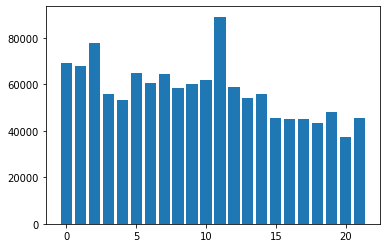

In [543]:
plt.bar(sales_month['月ブロック'], sales_month['売上個数'])

In [544]:
kosuu = merged_data.groupby(['商品ID']).agg({'売上個数':np.sum}).reset_index()
np.median(kosuu['売上個数'])
np.mean(kosuu['売上個数'])

139.6978982300885

12月(月ブロック:11)の売上個数が非常に多い傾向にあることがわかる。

# 3. 前処理

### 月ごとの売上を集計する(「商品ID」×「店舗ID」)

ここからは、モデルの学習を行うためのデータセットの作成作業に入る。<br>
『各店舗』×『各商品』の組み合わせについて、『2019年12月の1ヶ月間』における『合計売上個数』を予測する<br>
というのが今回のタスクであるため、学習用データをそれに従って再構成する。

In [545]:
# 「月ブロック」「商品ID」「店舗ID」でグルーピングし、売上個数の合計を取る
gp_month = sales.groupby(['月ブロック',  '商品ID', '店舗ID']).agg({'売上個数': np.sum}).reset_index()
gp_month

,月ブロック,商品ID,店舗ID,売上個数
0,0,1000001,0,6.0
1,0,1000001,1,2.0
2,0,1000001,2,1.0
3,0,1000001,3,2.0
4,0,1000001,5,2.0
...,...,...,...,...
495129,21,3500070,16,1.0
495130,21,3500071,13,1.0
495131,21,3500072,2,1.0
495132,21,3500072,16,1.0


### 「'月'、'商品ID'、 '店舗ID'」の全組み合わせを作成する

salesデータには、売上が0個の場合の履歴が含まれていない。<br>
そのため、モデルに『売上が0個となる』場合を正しく学習させるには、新たにデータを生成する必要がある。<br>
ここでは、「月」×「商品ID」×「店舗ID」の組み合わせを生成し、元のデータと統合することで、『売上が0個となる』場合も含めた売上履歴データの生成を試みる。

In [546]:
all_combination = []

# '月'、'商品ID'、 '店舗ID'の全組み合わせを作成する
columns = ['月ブロック', '商品ID', '店舗ID']

for i in range(22):
    train_block = sales[sales['月ブロック']==i]
    all_combination.append(np.array(list(product([i], train_block['商品ID'].unique(), train_block['店舗ID'].unique()))))
    
all_combination = pd.DataFrame(np.vstack(all_combination), columns=columns)
all_combination.sort_values(columns, inplace=True)

print(all_combination.info())
all_combination

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1648926 entries, 3 to 1644693
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   月ブロック   1648926 non-null  int64
 1   商品ID    1648926 non-null  int64
 2   店舗ID    1648926 non-null  int64
dtypes: int64(3)
memory usage: 50.3 MB
None


,月ブロック,商品ID,店舗ID
3,0,1000001,0
4,0,1000001,1
7,0,1000001,2
15,0,1000001,3
16,0,1000001,4
...,...,...,...
1644680,21,3500073,13
1644694,21,3500073,14
1644679,21,3500073,15
1644685,21,3500073,16


In [547]:
# all_combinationに売上履歴データを追加する
all_train = pd.merge(all_combination, gp_month, on=['月ブロック', '商品ID', '店舗ID'], how='left')

# 売上個数がNaNとなっている箇所は、売上個数0個として値を埋める
#all_train['売上個数'] = all_train['売上個数'].fillna(0)
all_train = all_train.dropna()

all_train

,月ブロック,商品ID,店舗ID,売上個数
0,0,1000001,0,6.0
1,0,1000001,1,2.0
2,0,1000001,2,1.0
3,0,1000001,3,2.0
5,0,1000001,5,2.0
...,...,...,...,...
1648870,21,3500070,16,1.0
1648885,21,3500071,13,1.0
1648892,21,3500072,2,1.0
1648906,21,3500072,16,1.0


In [548]:
gp_month2 = sales.groupby(['月ブロック','商品ID','店舗ID']).agg({'商品価格': np.mean}).reset_index()
all_train2 = pd.merge(all_train, gp_month2, on=['月ブロック','商品ID','店舗ID'], how='left')
all_train = all_train2

### testデータにカラムを追加する

In [549]:
new_test = test.copy()

# 評価対象期間が2019年12月(月ブロック: 23)であるという情報を追加
new_test['月ブロック'] = 23

new_test.head()

,index,商品ID,店舗ID,月ブロック
0,0,1000001,0,23
1,1,1000001,1,23
2,2,1000001,2,23
3,3,1000001,3,23
4,4,1000001,4,23


### 学習データとテストデータを縦に結合: pd.concat()

In [550]:
dataset = pd.concat([all_train, new_test])
dataset = dataset.drop('index', axis=1)
dataset

,月ブロック,商品ID,店舗ID,売上個数,商品価格
0,0,1000001,0,6.0,420.0
1,0,1000001,1,2.0,325.0
2,0,1000001,2,1.0,420.0
3,0,1000001,3,2.0,420.0
4,0,1000001,5,2.0,380.0
...,...,...,...,...,...
3055,23,3500001,13,NaN,NaN
3056,23,3500001,14,NaN,NaN
3057,23,3500001,15,NaN,NaN
3058,23,3500001,16,NaN,NaN


予測対象である月ブロック23(2019年12月)における売上履歴は当然存在しないため値はNaNとなる

# 4. 特徴量生成
- <font color="#FF0000"><strong>【ポイント】予測モデルの精度向上の為には適切な特徴量を追加することが一つのポイントとなりますので、どんな特徴量を作るべきかを検討しましょう</strong></font>
- こちらでは１年前の売上というラグ特徴量を紹介しています

### ラグ特徴量の作成

昨年度同月の売上個数が今年度の売上個数の予測に役立つのではないかという仮説のもとに、ラグ特徴量を生成する<br>
ここでは、月ブロックを1年分(12)ずらした上でデータを統合するという方法を取る。

In [551]:
lag1 = dataset.copy()  
lag1['月ブロック'] = lag1['月ブロック'] + 1
lag1 = lag1.rename(columns={'売上個数': '売上個数-1'})
lag1 = lag1.drop(['商品価格'], axis=1)

lag2 = dataset.copy()  
lag2['月ブロック'] = lag2['月ブロック'] + 2
lag2 = lag2.rename(columns={'売上個数': '売上個数-2'})
lag2 = lag2.drop(['商品価格'], axis=1)

lag3 = dataset.copy() 
lag3['月ブロック'] = lag3['月ブロック'] + 3
lag3 = lag3.rename(columns={'売上個数': '売上個数-3'})
lag3 = lag3.drop(['商品価格'], axis=1)

lag4 = dataset.copy() 
lag4['月ブロック'] = lag3['月ブロック'] + 4
lag4 = lag4.rename(columns={'売上個数': '売上個数-4'})
lag4 = lag4.drop(['商品価格'], axis=1)

lag5 = dataset.copy() 
lag5['月ブロック'] = lag3['月ブロック'] + 5
lag5 = lag5.rename(columns={'売上個数': '売上個数-5'})
lag5 = lag5.drop(['商品価格'], axis=1)

lag6 = dataset.copy() 
lag6['月ブロック'] = lag3['月ブロック'] + 6
lag6 = lag6.rename(columns={'売上個数': '売上個数-6'})
lag6 = lag6.drop(['商品価格'], axis=1)

lag7 = dataset.copy() 
lag7['月ブロック'] = lag3['月ブロック'] + 7
lag7 = lag7.rename(columns={'売上個数': '売上個数-7'})
lag7 = lag7.drop(['商品価格'], axis=1)

lag8 = dataset.copy() 
lag8['月ブロック'] = lag3['月ブロック'] + 8
lag8 = lag8.rename(columns={'売上個数': '売上個数-8'})
lag8 = lag8.drop(['商品価格'], axis=1)

lag9 = dataset.copy() 
lag9['月ブロック'] = lag3['月ブロック'] + 9
lag9 = lag9.rename(columns={'売上個数': '売上個数-9'})
lag9 = lag9.drop(['商品価格'], axis=1)

lag10 = dataset.copy() 
lag10['月ブロック'] = lag3['月ブロック'] + 10
lag10 = lag10.rename(columns={'売上個数': '売上個数-10'})
lag10 = lag10.drop(['商品価格'], axis=1)

lag11 = dataset.copy() 
lag11['月ブロック'] = lag3['月ブロック'] + 11
lag11 = lag11.rename(columns={'売上個数': '売上個数-11'})
lag11 = lag11.drop(['商品価格'], axis=1)

lag12 = dataset.copy() 
lag12['月ブロック'] = lag3['月ブロック'] + 12
lag12 = lag12.rename(columns={'売上個数': '売上個数-12'})
lag12 = lag12.drop(['商品価格'], axis=1)

### ラグ特徴量の追加

In [552]:
dataset2 = dataset.copy()
dataset2 = pd.merge(dataset2, lag1, on=['月ブロック', '商品ID', '店舗ID'], how='left', left_index=True)
dataset2 = pd.merge(dataset2, lag2, on=['月ブロック', '商品ID', '店舗ID'], how='left', left_index=True)
dataset2 = pd.merge(dataset2, lag3, on=['月ブロック', '商品ID', '店舗ID'], how='left', left_index=True)
dataset2 = pd.merge(dataset2, lag4, on=['月ブロック', '商品ID', '店舗ID'], how='left', left_index=True)
dataset2 = pd.merge(dataset2, lag5, on=['月ブロック', '商品ID', '店舗ID'], how='left', left_index=True)
dataset2 = pd.merge(dataset2, lag6, on=['月ブロック', '商品ID', '店舗ID'], how='left', left_index=True)
dataset2 = pd.merge(dataset2, lag7, on=['月ブロック', '商品ID', '店舗ID'], how='left', left_index=True)
dataset2 = pd.merge(dataset2, lag8, on=['月ブロック', '商品ID', '店舗ID'], how='left', left_index=True)
dataset2 = pd.merge(dataset2, lag9, on=['月ブロック', '商品ID', '店舗ID'], how='left', left_index=True)
dataset2 = pd.merge(dataset2, lag10, on=['月ブロック', '商品ID', '店舗ID'], how='left', left_index=True)
dataset2 = pd.merge(dataset2, lag11, on=['月ブロック', '商品ID', '店舗ID'], how='left', left_index=True)
dataset2 = pd.merge(dataset2, lag12, on=['月ブロック', '商品ID', '店舗ID'], how='left', left_index=True)

In [553]:
# 定価
teika = dataset.copy()  

print(dataset["商品価格"].describe())

teika = dataset.groupby(['商品ID']).agg({'商品価格': np.max}).rename(columns={'商品価格': 'teika'}).reset_index()
urine = dataset.groupby(['商品ID']).agg({'商品価格': np.median}).rename(columns={'商品価格': 'urine'}).reset_index()

teika = teika[teika['teika'] <= 500000]

print("max:", teika["teika"].max())
print("min:", teika["teika"].min())


count    495134.000000
mean        915.372419
std        1373.195196
min           0.000000
25%         340.000000
50%         510.000000
75%        1020.000000
max      523570.000000
Name: 商品価格, dtype: float64
max: 71400.0
min: 20.0


In [554]:
# 発売月
hatubai = dataset.groupby(['商品ID']).agg({'月ブロック': np.min}).rename(columns={'月ブロック': 'hatubai'}).reset_index()




In [555]:
shouhin_sum = dataset.groupby(['商品ID']).agg({'売上個数': np.sum}).reset_index().rename(columns={'売上個数': 'shouhin_sum'}).reset_index()


↑ 「月ブロック」0〜11のデータに該当するデータは、12ヶ月前の売上履歴が存在しないので、カラム「12ヶ月前の売上個数」すべて欠損値となる

### 「商品カテゴリ」「年・月」情報の追加

In [556]:
dataset3 = pd.merge(dataset2, cats, on='商品ID', how='left')
dataset3 = pd.merge(dataset3, gp_time, on='月ブロック', how='left')
dataset3 = pd.merge(dataset3, teika, on='商品ID', how='left')
dataset3 = pd.merge(dataset3, urine, on='商品ID', how='left')
dataset3 = pd.merge(dataset3, hatubai, on='商品ID', how='left')
dataset3['hatubaigo'] = dataset3['月ブロック'] - dataset3['hatubai']
dataset3 = pd.merge(dataset3, shouhin_sum, on='商品ID', how='left')

### 文字列データを数値データに直す: pandas.Series.astype()

In [557]:
dataset3['年'] = dataset3['年'].astype(int)
dataset3['月'] = dataset3['月'].astype(int)

### 欠損値を0で埋める

In [558]:
print(dataset3)
#dataset3 = dataset3.fillna(0)
dataset3[dataset3['月ブロック'] == 23] = dataset3[dataset3['月ブロック'] == 23].fillna(0)
dataset_tmp = dataset3

        月ブロック     商品ID  店舗ID  売上個数   商品価格  売上個数-1  売上個数-2  売上個数-3  売上個数-4  \
0           0  1000001     0   6.0  420.0     NaN     NaN     NaN     NaN   
1           0  1000001     1   2.0  325.0     NaN     NaN     NaN     NaN   
2           0  1000001     2   1.0  420.0     NaN     NaN     NaN     NaN   
3           0  1000001     3   2.0  420.0     NaN     NaN     NaN     NaN   
4           0  1000001     5   2.0  380.0     NaN     NaN     NaN     NaN   
...       ...      ...   ...   ...    ...     ...     ...     ...     ...   
498189     23  3500001    13   NaN    NaN     NaN     2.0     3.0     2.0   
498190     23  3500001    14   NaN    NaN     NaN     NaN     NaN     NaN   
498191     23  3500001    15   NaN    NaN     NaN     NaN     NaN     1.0   
498192     23  3500001    16   NaN    NaN     NaN     NaN     NaN     NaN   
498193     23  3500001    17   NaN    NaN     NaN     NaN     NaN     NaN   

        売上個数-5  売上個数-6  売上個数-7  売上個数-8  売上個数-9  売上個数-10  売上個数-11  売上個数-12  

## データセットの整理

In [559]:
dataset3 = dataset_tmp.copy()

dataset3['shouhin_cumsum'] = dataset3.groupby(['商品ID']).cumsum()['売上個数-1']
#dataset3.loc[ dataset3['shouhin_cumsum'] ==  dataset3['shouhin_cumsum'],'tenpo_newsflg'] = 1
#dataset3.loc[ dataset3['shouhin_cumsum'] !=  dataset3['shouhin_cumsum'],'tenpo_newsflg'] = 0
dataset3.loc[ dataset3['shouhin_cumsum'] > 0,'shouhin_nosell'] = 0
dataset3.loc[ dataset3['shouhin_cumsum'] == 0 ,'shouhin_nosell'] = 1

dataset3['shouhin_cumsum-2'] = dataset3.groupby(['商品ID']).cumsum()['売上個数-2']
dataset3.loc[ dataset3['shouhin_cumsum-2'] > 0,'shouhin_nosell-2'] = 0
dataset3.loc[ dataset3['shouhin_cumsum-2'] == 0 ,'shouhin_nosell-2'] = 1

dataset3['tenpo_cumsum'] = dataset3.groupby(['商品ID','店舗ID']).cumsum()['売上個数-1']
#dataset3.loc[ dataset3['tenpo_cumsum'] ==  dataset3['売上個数'],'tenpo_newsflg'] = 1
#dataset3.loc[ dataset3['tenpo_cumsum'] !=  dataset3['売上個数'],'tenpo_newsflg'] = 0
dataset3.loc[ dataset3['tenpo_cumsum'] > 0,'tenpo_nosell'] = 0
dataset3.loc[ dataset3['tenpo_cumsum'] == 0 ,'tenpo_nosell'] = 1

dataset3['tenpo_cumsum-2'] = dataset3.groupby(['商品ID','店舗ID']).cumsum()['売上個数-2']
dataset3.loc[ dataset3['tenpo_cumsum-2'] > 0,'tenpo_nosell-2'] = 0
dataset3.loc[ dataset3['tenpo_cumsum-2'] == 0 ,'tenpo_nosell-2'] = 1


#dataset4['mean12'] = dataset4.groupby(['商品ID','店舗ID'])['売上個数'].rolling(12).mean()
#dataset4['mean4'] = dataset.groupby(['月ブロック','商品ID','店舗ID'],group_keys=False).rolling(window=3).mean()['売上個数']

dataset3['mean3'] = dataset3[['売上個数-2','売上個数-3','売上個数-4']].mean(axis=1)
dataset3['mean6'] = dataset3[['売上個数-2','売上個数-3','売上個数-4','売上個数-5','売上個数-6','売上個数-7']].mean(axis=1)
dataset3['mean11'] = dataset3[['売上個数-2','売上個数-3','売上個数-4','売上個数-5','売上個数-6','売上個数-7','売上個数-8','売上個数-9','売上個数-10','売上個数-11','売上個数-12']].mean(axis=1)
dataset3 = pd.get_dummies(dataset3, columns=['月'])

#dataset3.to_csv('dataset3.csv', index=False)

In [560]:
dataset3[dataset3['shouhin_nosell'] == 0].sort_values('売上個数', ascending=False)
#dataset3.sort_values('売上個数', ascending=False)

,月ブロック,商品ID,店舗ID,売上個数,商品価格,売上個数-1,売上個数-2,売上個数-3,売上個数-4,売上個数-5,売上個数-6,売上個数-7,売上個数-8,売上個数-9,売上個数-10,売上個数-11,売上個数-12,商品カテゴリID,年,teika,urine,hatubai,hatubaigo,index,shouhin_sum,shouhin_cumsum,shouhin_nosell,shouhin_cumsum-2,shouhin_nosell-2,tenpo_cumsum,tenpo_nosell,tenpo_cumsum-2,tenpo_nosell-2,mean3,mean6,mean11,月_1,月_2,月_3,月_4,月_5,月_6,月_7,月_8,月_9,月_10,月_11,月_12
234501,9,1100302,9,260.0,1275.000000,7.0,12.0,11.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110,2018,2040.0,1217.416667,2,7,2928,4895.0,2554.0,0.0,2427.0,0.0,150.0,0.0,143.0,0.0,32.333333,32.333333,32.333333,0,0,0,0,0,0,0,0,0,1,0,0
257360,10,1100375,6,177.0,2040.000000,93.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110,2018,2040.0,1745.878852,9,1,3001,8714.0,252.0,0.0,NaN,NaN,93.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,0
280373,11,1100375,6,175.0,1797.878788,177.0,93.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110,2018,2040.0,1745.878852,9,2,3001,8714.0,1297.0,0.0,252.0,0.0,270.0,0.0,93.0,0.0,93.000000,93.000000,93.000000,0,0,0,0,0,0,0,0,0,0,0,1
257364,10,1100375,10,170.0,1926.451613,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110,2018,2040.0,1745.878852,9,1,3001,8714.0,332.0,0.0,NaN,NaN,38.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,0
409006,17,1100336,9,160.0,130.000000,4.0,1.0,3.0,NaN,1.0,4.0,2.0,9.0,15.0,NaN,NaN,NaN,110,2019,1020.0,300.000000,5,12,2962,2017.0,1466.0,0.0,1262.0,0.0,44.0,0.0,37.0,0.0,2.000000,2.200000,5.000000,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331268,13,1200297,0,-1.0,340.000000,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,120,2019,340.0,340.000000,0,13,3374,135.0,49.0,0.0,44.0,0.0,2.0,0.0,1.0,0.0,1.000000,1.000000,1.000000,0,1,0,0,0,0,0,0,0,0,0,0
389284,16,1100046,6,-1.0,510.000000,4.0,4.0,2.0,4.0,11.0,12.0,9.0,14.0,7.0,6.0,10.0,9.0,110,2019,510.0,510.000000,0,16,2672,1545.0,1491.0,0.0,1423.0,0.0,123.0,0.0,119.0,0.0,3.333333,7.000000,8.000000,0,0,0,0,1,0,0,0,0,0,0,0
187711,7,1100336,12,-2.0,1020.000000,1.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110,2018,1020.0,300.000000,5,2,2962,2017.0,896.0,0.0,569.0,0.0,33.0,0.0,32.0,0.0,32.000000,32.000000,32.000000,0,0,0,0,0,0,0,1,0,0,0,0
94798,3,1300033,12,-2.0,3740.000000,1.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130,2018,3740.0,3463.333333,0,3,4448,369.0,168.0,0.0,117.0,0.0,7.0,0.0,6.0,0.0,3.000000,3.000000,3.000000,0,0,0,1,0,0,0,0,0,0,0,0


In [561]:
#dataset3 = dataset3[dataset3['shouhin_nosell'] == 0]
#dataset3 = dataset3[dataset3['shouhin_nosell-2'] == 0]

dataset3 = dataset3[[
                     '月ブロック',
                     '商品ID',
                     'shouhin_sum',
#                     'tenpo_cumsum',
                     'tenpo_nosell',
#                     'shouhin_cumsum',
#                     'shouhin_nosell',
#                     'tenpo_cumsum-2',
#                     'tenpo_nosell-2',
#                     'shouhin_cumsum-2',
#                     'shouhin_nosell-2',
                     '店舗ID',
                     '売上個数',
                     '商品カテゴリID',
#                     '商品価格',
                     '売上個数-2',
                     '売上個数-3',
#                     '売上個数-4',
#                     '売上個数-5',
#                     '売上個数-12',
                     'mean3',
#                     'mean6',
#                     'mean11',
#                     '年',
                     '月_12',
#                     'teika',
#                     'urine',
                     'hatubaigo',
                     ]]
#dataset3 = pd.get_dummies(dataset3, columns=['店舗ID'])
#dataset3 = pd.get_dummies(dataset3, columns=['商品ID'])
# dataset3 = pd.get_dummies(dataset3, columns=['商品カテゴリID'])

### データセットを学習用とテスト用に分割する

In [562]:
# # 学習データとしては、「12ヶ月前の売上個数」カラムが存在するレコードのみを抽出する
# #train_dataset = dataset3[(dataset3['月ブロック'] >= 12) & (dataset3['月ブロック'] != 23) & (dataset3['月ブロック'] != 21)]
# train_dataset = dataset3[(dataset3['月ブロック'] >= 4) & (dataset3['月ブロック'] < 20)]
# test_dataset = dataset3[dataset3['月ブロック'] == 20]

In [563]:
# train_dataset

In [564]:
# test_dataset.head(1000)

### データセットを入力値、目標値に分割

In [565]:
# X_train = train_dataset.drop(['売上個数','月ブロック'], axis=1)
# y_train = train_dataset['売上個数']

# X_test = test_dataset.drop(['売上個数','月ブロック'], axis=1)
# y_test = test_dataset['売上個数']



# 5. モデリング
- <font color="#FF0000"><strong>【ポイント】利用するモデルによっても予測精度は変わります。様々なモデル×パラメータチューニングを試してみましょう。</strong></font>
- ここでは、特徴量の正規化などは行わずに単純な重回帰モデルによる学習・予測を行った場合の例を示す。

In [566]:
# import lightgbm as lgb
# # モデルの学習
# model = lgb.LGBMRegressor(
#     objective='regression',
#     num_leaves=64,
#     min_child_samples=20,
#     max_depth=7
# ) # モデルのインスタンスの作成
# model.fit(X_train, y_train) # モデルの学習

In [567]:
# # 学習済みのモデルを使用してテストデータに関する予測値を算出する
# y_pred = model.predict(X_test)

# from sklearn.metrics import mean_squared_error
# print(np.sqrt(mean_squared_error(y_test, y_pred)))

# lgb.plot_importance(model, figsize=(8,4), max_num_features=10, importance_type='gain')

# 6. 提出用ファイルの作成: pandas.DataFrame.to_csv()

sample_submission.csvを元に、提出用ファイルを作成する

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 33303 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22770 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_

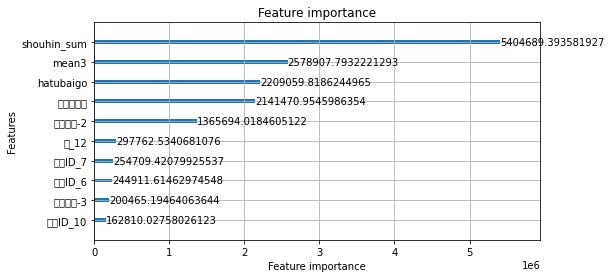

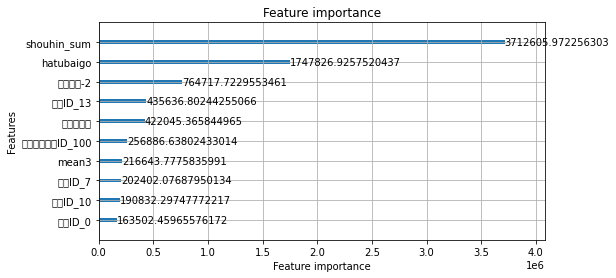

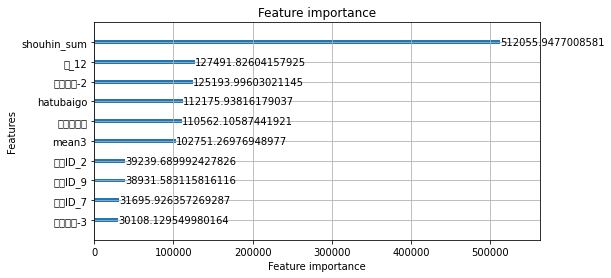

In [568]:
import lightgbm as lgb
ans = pd.read_csv('test.csv')
category_list = [[110,220,150,130,310,340,320,160],[100,230,140,200,270,350,300,250,120,330,190],[210,170,260,180,240,280,290]]
for i in category_list:
  target = dataset3[dataset3['商品カテゴリID'].isin(i)]
  y_ans_pred2 = target[target['月ブロック'] == 23][['商品ID','店舗ID']]

  target = pd.get_dummies(target, columns=['店舗ID'])
  target = pd.get_dummies(target, columns=['商品カテゴリID'])
  target = target.drop(['商品ID'], axis=1)

  train_dataset = target[(target['月ブロック'] >= 7) & (target['月ブロック'] != 23)]
  test_dataset = target[target['月ブロック'] == 23]

  X_train = train_dataset.drop(['売上個数'], axis=1)
  y_train = train_dataset['売上個数']

  X_test = test_dataset.drop(['売上個数'], axis=1)
  y_test = test_dataset['売上個数']

  # X_train = pd.get_dummies(X_train, columns=['店舗ID'])
  # X_test = pd.get_dummies(X_test, columns=['店舗ID'])
  # X_train = pd.get_dummies(X_train, columns=['商品ID'])
  # X_test = pd.get_dummies(X_test, columns=['商品ID'])
  # X_train = pd.get_dummies(X_train, columns=['商品カテゴリID'])
  # X_test = pd.get_dummies(X_test, columns=['商品カテゴリID'])

  # モデルの学習
  model = lgb.LGBMRegressor(
      objective='regression',
      num_leaves=64,
      min_child_samples=20,
      max_depth=7
  ) # モデルのインスタンスの作成
  model.fit(X_train, y_train) # モデルの学習
  lgb.plot_importance(model, figsize=(8,4), max_num_features=10, importance_type='gain')
  y_ans_pred = model.predict(X_test)

  y_ans_pred2['予測値'] = y_ans_pred
  ans = pd.merge(ans, y_ans_pred2, on=['商品ID','店舗ID'], how='left')
  ans = ans.fillna(0)


In [569]:
print(ans)
ans['yosoku'] = ans[['予測値','予測値_x','予測値_y']].max(axis=1)
ans = ans.drop(['予測値','予測値_x','予測値_y','index'], axis=1)
# ans['yosoku'] = ans[['予測値_x','予測値_y']].max(axis=1)
# ans = ans.drop(['予測値_x','予測値_y','index'], axis=1)
print(ans)

      index     商品ID  店舗ID  予測値_x     予測値_y  予測値
0         0  1000001     0    0.0  1.834843  0.0
1         1  1000001     1    0.0  1.597126  0.0
2         2  1000001     2    0.0  1.727114  0.0
3         3  1000001     3    0.0  2.634419  0.0
4         4  1000001     4    0.0  5.542696  0.0
...     ...      ...   ...    ...       ...  ...
3055   3055  3500001    13    0.0  1.871805  0.0
3056   3056  3500001    14    0.0  1.132041  0.0
3057   3057  3500001    15    0.0  1.189854  0.0
3058   3058  3500001    16    0.0  1.084608  0.0
3059   3059  3500001    17    0.0  1.207875  0.0

[3060 rows x 6 columns]
         商品ID  店舗ID    yosoku
0     1000001     0  1.834843
1     1000001     1  1.597126
2     1000001     2  1.727114
3     1000001     3  2.634419
4     1000001     4  5.542696
...       ...   ...       ...
3055  3500001    13  1.871805
3056  3500001    14  1.132041
3057  3500001    15  1.189854
3058  3500001    16  1.084608
3059  3500001    17  1.207875

[3060 rows x 3 columns]


In [570]:
# # submit_df = pd.DataFrame(index=[], columns=['id','y'])
# ans_regression=[]

# # 学習データとしては、「12ヶ月前の売上個数」カラムが存在するレコードのみを抽出する
# train_dataset = dataset3[(dataset3['月ブロック'] >= 7) & (dataset3['月ブロック'] != 23)].copy()
# test_dataset = dataset3[dataset3['月ブロック'] == 23].copy()

# for i in range(len(test)):
# # for i in range(1):
#   target = test.iloc[i,1:].copy()
#   shouhin = target['商品ID']
#   tenpo = target['店舗ID']
#   X_train = train_dataset[(train_dataset['商品ID'] == shouhin) & (train_dataset['店舗ID'] == tenpo)].drop(['月ブロック','商品ID','店舗ID','売上個数'],axis=1)
#   y_train = train_dataset[(train_dataset['商品ID'] == shouhin) & (train_dataset['店舗ID'] == tenpo)]['売上個数']
#   X_test = test_dataset[(test_dataset['商品ID'] == shouhin) & (test_dataset['店舗ID'] == tenpo)].drop(['月ブロック','商品ID','店舗ID','売上個数'],axis=1)
#   y_test = test_dataset[(test_dataset['商品ID'] == shouhin) & (test_dataset['店舗ID'] == tenpo)]['売上個数']
#   # print(target['商品ID'],target['店舗ID'],len(X_test))

#   model= LinearRegression()
#   #model = lgb.LGBMRegressor()
#   model.fit(X_train, y_train)
#   y_pred = model.predict(X_test)

#   # submit_df = submit_df.append({'id':name,'y':ans[0,0]}, ignore_index=True)
#   ans_regression.append(max(round(y_pred[0],8),0))



In [571]:
# ans_ansanble = (ans['yosoku'] + ans_regression) /2
# print(ans['yosoku'])
# print( ans_regression)
# print(ans_ansanble)

In [572]:
# sample_submissionの右側のカラムに予測値を代入する。
# sub.iloc[:, -1] = ans_ansanble
sub.iloc[:, -1] = ans['yosoku']

sub.head()

,0,1
0,0,1.834843
1,1,1.597126
2,2,1.727114
3,3,2.634419
4,4,5.542696


In [573]:
# 予測ファイルの生成
sub.to_csv('my_submission.csv', index=False, header=False)